In [23]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split

# Load your dataset
file_path = "/Users/batoolalfouzan/Desktop/books-main/Cleaned Dataset/Book_Cleaned_Dataset_.xls"  # Update the path accordingly
df = pd.read_csv(file_path)

# ----------------- Decode Categories -----------------
def decode_categories(df):
    category_map = {
        "الأدب والخيال": "1",
        "الكتب الإسلامية": "10",
        "الاقتصاد والأعمال": "100",
        "الفلسفة": "1000",
        "الصحافة والإعلام": "10000",
        "الكتب السياسية": "100000",
        "العلوم والطبيعة": "1000000",
        "الأسرة والطفل": "10000000",
        "السير والمذكرات": "100000000",
        "الفنون": "1000000000",
        "التاريخ والجغرافيا": "10000000000",
        "الرياضة والتسلية": "100000000000",
        "الشرع والقانون": "1000000000000"
    }
    
    reversed_category_map = {v: k for k, v in category_map.items()}
    
    df['Category'] = df['Category'].astype(str)
    
    def safe_map_category(x):
        if pd.isna(x) or x == 'nan':
            return np.nan
        x_str = str(int(x))
        return reversed_category_map.get(x_str, x)
    
    df['Category_original'] = df['Category'].apply(safe_map_category)
    return df

# Apply category decoding
df = decode_categories(df)

# ----------------- Combine Title and Description for embeddings -----------------
df['Title_Description'] = df['Title'] + " " + df['Description']

# ----------------- Initialize the BERT model and tokenizer for embeddings -----------------
tokenizer = AutoTokenizer.from_pretrained('asafaya/bert-base-arabic')
model = AutoModel.from_pretrained('asafaya/bert-base-arabic')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to generate embeddings
def generate_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Use mean pooling to get embeddings
    return embeddings

# Generate embeddings for the combined Title and Description
title_description_embeddings = generate_embeddings(df['Title_Description'].tolist())

# Store the embeddings as a list in the DataFrame
df['Title_Description_embedded'] = list(title_description_embeddings)

# ----------------- Prepare data for training -----------------
# Now assuming 'Category_original' is your target variable
X = df['Title_Description_embedded'].apply(np.array).tolist()  # Convert embeddings column to lists
X = np.array(X)  # Convert the list to a numpy array

y = df['Category_original']  # Target variable (the actual categories)

# ----------------- Split the data into training and testing sets -----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Save y_test as a CSV file -----------------
y_test_df = pd.DataFrame(y_test)  # Convert to DataFrame for saving
y_test_df.to_csv("y_test.csv", index=False)

print("y_test.csv file saved successfully!")

y_test.csv file saved successfully!


SVM Model Metrics:
Accuracy: 0.6212
F1-Score: 0.6185
Precision: 0.6218
Recall: 0.6212

SVM Classification Report:
                    precision    recall  f1-score   support

     الأدب والخيال       0.62      0.72      0.67       112
     الأسرة والطفل       0.59      0.60      0.59        50
 الاقتصاد والأعمال       0.67      0.74      0.71        82
التاريخ والجغرافيا       0.25      0.28      0.26        18
  الرياضة والتسلية       0.56      0.45      0.50        11
   السير والمذكرات       0.55      0.48      0.51        44
    الشرع والقانون       0.25      1.00      0.40         1
  الصحافة والإعلام       0.51      0.53      0.52        36
   العلوم والطبيعة       0.73      0.69      0.71        51
           الفلسفة       0.67      0.70      0.68        99
            الفنون       0.00      0.00      0.00         8
   الكتب الإسلامية       0.70      0.62      0.66        74
    الكتب السياسية       0.65      0.50      0.56        74

          accuracy                          

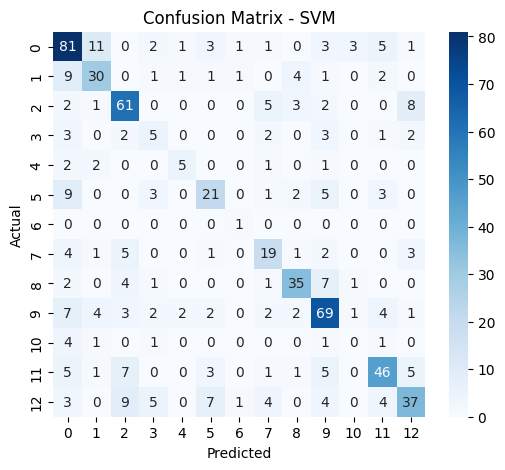

SVM might be overfitting (training accuracy much higher than test accuracy).


In [24]:
#svm analysis
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load test labels and predictions
y_test = pd.read_csv("y_test.csv")
y_pred_svm = pd.read_csv("y_pred_svm.csv")  # Predictions from SVM

# Compute metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
precision_svm = precision_score(y_test, y_pred_svm, average="weighted", zero_division=1)
recall_svm = recall_score(y_test, y_pred_svm, average="weighted", zero_division=1)

# Display metrics for SVM
print("SVM Model Metrics:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")

# Classification Report for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix for SVM
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

# Overfitting/Underfitting check for SVM
train_accuracy_svm = 0.9913  
cv_score_svm = 0.5889  

if train_accuracy_svm - accuracy_svm > 0.1:
    print("SVM might be overfitting (training accuracy much higher than test accuracy).")
elif accuracy_svm < 0.7:
    print("SVM might be underfitting (low test accuracy).")
else:
    print("SVM seems well balanced.")

CatBoost Model Metrics:
Accuracy: 0.6788
F1-Score: 0.6634
Precision: 0.7020
Recall: 0.6788

CatBoost Classification Report:
                    precision    recall  f1-score   support

     الأدب والخيال       0.68      0.82      0.74       112
     الأسرة والطفل       0.62      0.68      0.65        50
 الاقتصاد والأعمال       0.78      0.76      0.77        82
التاريخ والجغرافيا       0.67      0.22      0.33        18
  الرياضة والتسلية       1.00      0.09      0.17        11
   السير والمذكرات       0.72      0.48      0.58        44
    الشرع والقانون       0.00      0.00      0.00         1
  الصحافة والإعلام       0.94      0.42      0.58        36
   العلوم والطبيعة       0.77      0.67      0.72        51
           الفلسفة       0.64      0.81      0.71        99
            الفنون       0.00      0.00      0.00         8
   الكتب الإسلامية       0.65      0.70      0.68        74
    الكتب السياسية       0.60      0.72      0.65        74

          accuracy                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

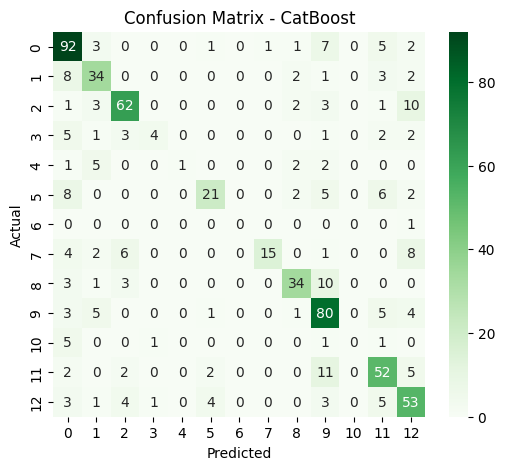

CatBoost might be overfitting (training accuracy much higher than test accuracy).


In [25]:
#catboost analysis
# Load predictions for CatBoost
y_pred_catboost = pd.read_csv("y_pred_catboost.csv")

# Compute metrics for CatBoost
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost, average="weighted")
precision_catboost = precision_score(y_test, y_pred_catboost, average="weighted", zero_division=1)
recall_catboost = recall_score(y_test, y_pred_catboost, average="weighted", zero_division=1)

# Display metrics for CatBoost
print("CatBoost Model Metrics:")
print(f"Accuracy: {accuracy_catboost:.4f}")
print(f"F1-Score: {f1_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")

# Classification Report for CatBoost
print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_catboost))

# Confusion Matrix for CatBoost
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_catboost), annot=True, cmap="Greens", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost")
plt.show()

# Overfitting/Underfitting check for CatBoost
train_accuracy_catboost = 0.9492 
cv_score_catboost = 0.5484  

if train_accuracy_catboost - accuracy_catboost > 0.1:
    print("CatBoost might be overfitting (training accuracy much higher than test accuracy).")
elif accuracy_catboost < 0.7:
    print("CatBoost might be underfitting (low test accuracy).")
else:
    print("CatBoost seems well balanced.")

## Model Comparison: SVM vs. CatBoost

In this analysis, we compare the performance of two machine learning models: SVM and CatBoost. The metrics considered for comparison include:
	•	Accuracy: Measures the percentage of correct predictions.
	•	F1-Score: Balances both precision and recall, especially useful for imbalanced classes.
	•	Precision: Measures the proportion of positive predictions that are actually correct.
	•	Recall: Measures the proportion of actual positives that were correctly identified.
	•	Cross-validation score: Assesses the model’s performance and stability across multiple folds of the data.
	•	Confusion Matrix: Helps understand the model’s predictions across all classes.



---

### SVM Model Performance:
- **Accuracy**: 0.6212
- **F1-Score**: 0.6185
- **Precision**: 0.6218
- **Recall**: 0.6212
- **Training Accuracy**: 0.9913
- **Test Accuracy**: 0.6212
- **Mean Cross-validation Score**: 0.5889

**Observations:**
- The training accuracy (0.9913) is significantly higher than the test accuracy (0.6212), indicating severe overfitting.
- The cross-validation score (0.5889) is lower than the test accuracy, suggesting that the model does not generalize well across different subsets of the data.

---

### CatBoost Model Performance:
- **Accuracy**: 0.6788
- **F1-Score**: 0.6634
- **Precision**: 0.7020
- **Recall**: 0.6788
- **Training Accuracy**: 0.9492
- **Test Accuracy**: 0.6833
- **Mean Cross-validation Score**: 0.5483

**Observations:**
- The training accuracy (0.9492) is also significantly higher than the test accuracy (0.6833), indicating overfitting, but it is less severe compared to SVM.
- The cross-validation score (0.5483) is lower than the test accuracy, meaning the model struggles slightly with generalization.

---

### Overfitting/Underfitting Analysis:
Both models exhibit overfitting, as indicated by the large gap between training accuracy and test accuracy. However, the severity of overfitting differs between the two models.

**Key Observations:**
- SVM has more severe overfitting, as the test accuracy is much lower than the training accuracy.
- CatBoost, while still overfitting, generalizes slightly better than SVM.
- CatBoost has a higher test accuracy (0.6833 vs. 0.6212), indicating that it performs better on unseen data.

---

### Conclusion: The Best Model to Choose

Based on the results, the CatBoost model is the better choice.

**Reasons:**
- Higher test accuracy (0.6833 vs. 0.6212), meaning it performs better on unseen data.
- Better F1-score, precision, and recall, indicating a more balanced performance.
- Less severe overfitting compared to SVM, making it a more generalizable model.

While both models require further tuning to reduce overfitting, CatBoost is the more suitable option for this task.